# Laboratory 07
Motion Planning and Control using Pure Pursuit

In [3]:
# Utility functions for pure pursuit solution
import sympy
from sympy import symbols, Matrix
from utils import pi2pi
#%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np

---
## Objective

- Implement the Pure Pursuit algorithm in a Python script
- Run a path following simulation with the implemented script
- Understand the limitations of the Pure Pursuit algorithm



---
## Mathematical Models

### Differential drive Motion Model

Using the SymPy library implement the Differential drive Motion Model that is explained in the lecture slides. For clearness the main equation of the model is reported below.\
In the robot frame the motion model is given by:

$$
\begin{pmatrix} x' \\ y' \\ \theta' \end{pmatrix} = g(u_t,x_{t-1}) = 
\begin{pmatrix} x \\ y \\ \theta \end{pmatrix} + 
\begin{pmatrix} v_t\cos{\theta} \Delta t \\ v_t\sin{\theta} \Delta t \\ \omega_t \Delta t
\end{pmatrix} 
$$
  
  where $v_t$ and $\omega_t$ are the linear and angular velocities of the robot, respectively.

In [6]:
x, y, theta, v, w, dt = symbols('x y theta v w dt')
gux = Matrix([
    x + (v * sympy.cos(theta) * dt), 
    y + (v * sympy.sin(theta) * dt), 
    theta + (w * dt)
])

In [7]:
eval_gux = sympy.lambdify((x, y, theta, v, w, dt), gux, 'numpy')

### Velocity update

Using the SymPy library implement the velocity update function. For clearness the main equation of the model is reported below.

$$
v_{t} = f(v,a) = 
\left(
    v_{t-1} + a \Delta t
\right)
$$

Write in the following cell the code to compute the update to the velocity. Remember to convert the symbolic functions to Python functions that can be evaluated as done in the previous step.

In [8]:
a, vt_1 = symbols(r'a v_{t-1}')
fva = vt_1 + (a*dt)
eval_fva = sympy.lambdify((vt_1, a, dt), fva, 'numpy')

---
## Robot Class

Complete the `Robot` Class with the equations where you find the symbol `...`


#### Robot Initialization

In the function `__init__` the robot is initialized given the dimensions of the state `dim_x`, of the input `dim_u`.

In [9]:
import math
import numpy as np


class Robot:
    def __init__(
        self, dim_x=1, dim_u=1, eval_gux=None, eval_fva=None
    ):
        """
        Initialize the robot creating the necessary matrices
        """
        self.x = np.zeros((dim_x, 1))  # state variables
        self.u = np.zeros((dim_u, 1))  # control variables
        
        self.eval_gux = eval_gux
        self.eval_fva = eval_fva

        # Robot properties
        self.max_linear_velocity = 0.22 # m/s
        self.max_angular_velocity = 1.5 # rad/s
        self.max_acceleration = 0.5 # m/s^2

    @property
    def v(self):
        return self.u[0, 0]
    
    @property
    def w(self):
        return self.u[1, 0]
    

#### Robot update velocity

Use the function `velocity_update` to compute the velocity update.

$$
v_{t} = f(v,a)
$$

Complete where you find the symbol `...` using the equations of motion.

In [10]:
def velocity_update(self, a, dt):
    """
    Update the state of the robot using the control input u

    Modified variables:
    self.u: updated input
    """
    # Update the state evauating the motion model
    # Saturate the velocities with np.clip(value, min, max)
    a = np.clip(a, -self.max_acceleration, self.max_acceleration) # saturate the acceleration 
    self.u[0] = self.eval_fva(self.u[0], a, dt)  # evaluate the velocity update
    self.u[0] = np.clip(self.u[0], -self.max_linear_velocity, self.max_linear_velocity) # saturate the velocity
    return self.u[0] 
    
Robot.velocity_update = velocity_update

#### Robot update state

The function `update_state` implement the simulation step given an input velocity and a time interval.

Complete where you find the symbol `...` using the equations of motion.

$$
\begin{aligned}
{x}_t =& g(u_t, x_{t-1}) \\
\end{aligned}
$$

In [11]:
def update_state(self, a, w, dt):
    """
    Update the state of the robot using the control input u

    Modified variables:
    self.x: updated state
    """
    w_ = np.clip(w, -self.max_angular_velocity, self.max_angular_velocity) # clip the angular velocity
    v_ = self.velocity_update(a, dt) # update the velocity
    # Update the state evauating the motion model
    self.x = self.eval_gux(self.x[0], self.x[1], self.x[2], v, w, dt) # evaluate the motion model
    self.x[2] = np.arctan2(np.sin(self.x[2]), np.cos(self.x[2]))  # normalize the orientation between [-pi, pi]
Robot.update_state = update_state

#### Input control (Proportional Controller)

The function `proportional_control` implement the proportional controller to compute the acceleration given the current velocity and the target velocity.

$$
a = k_p \left( v_{target} - v \right)
$$

In [12]:
def proportional_control(v_target, v_current, kp=3.0):
    """
    Compute the control input using proportional control law
    a = kp * (v_target - v_current)

    Args:
    v_target: target velocity
    v_current: current velocity

    Return:
    a: control input computed using proportional control
    """
    a = kp * (v_target - v_current)
    return a

## Target Path

The target trajectory is a complex path that is composed by a sequence of waypoints. The waypoints are defined in the following cell. The target trajectory is then generated using a spline interpolation between the waypoints and a function that compute the tangent to the spline.

The target trajectory is then plotted in the following cell.

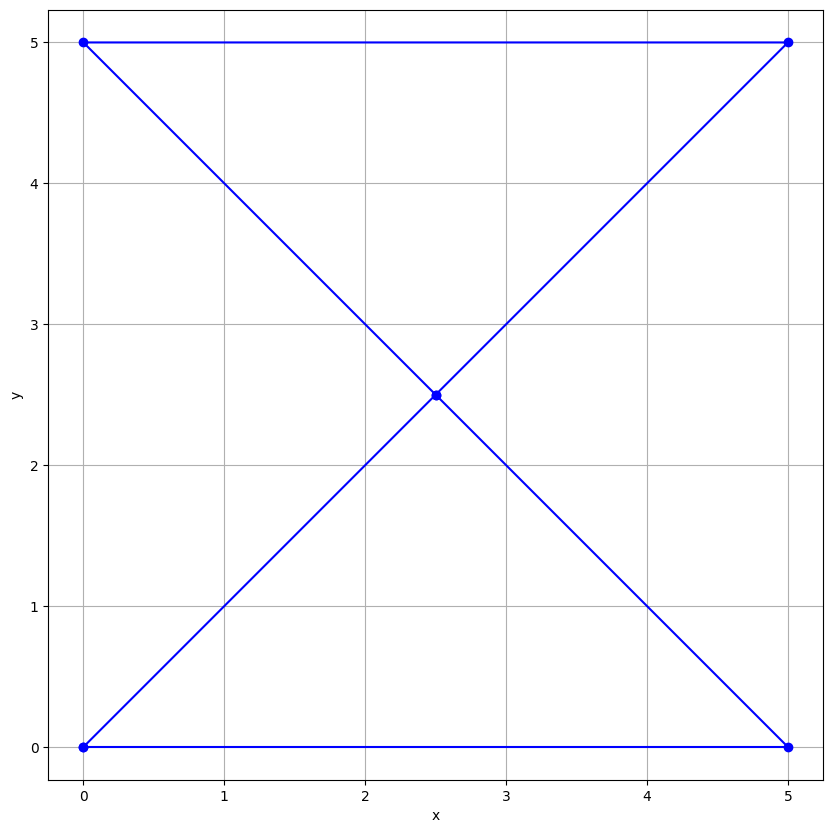

In [13]:
from utils import interpolate_waypoints

waypoints = np.array([
    [0.0, 0.0],
    [2.5, 2.5],
    [0.0, 5.0],
    [5.0, 5.0],
    [2.5, 2.5],
    [5.0, 0.0],
    [0.0, 0.0],
])



interpolated_waypoints = interpolate_waypoints(waypoints, resolution=0.01)

plt.figure(figsize=(10, 10))
plt.plot(interpolated_waypoints[:, 0], interpolated_waypoints[:, 1], 'b')
plt.plot(waypoints[:, 0], waypoints[:, 1], 'bo')
plt.grid()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Pure Pursuit Algorithm

The Pure Pursuit algorithm is implemented in the function `pure_pursuit_control` that takes as input the current state of the robot and the path to follow. The function returns the target velocity and the target angular velocity.

The algorithm is composed by the following steps:

1. Compute the lookahead point on the path $p_l = (x_l, y_l)$
2. Compute the target velocity $v_{target}$
3. Compute the angular velocity $\omega$

In [14]:
class PurePursuitController:
    def __init__(self, robot, path, pind, Lt, vt, *args,**kwargs):
        """
        Initialize the controller using the robot and the path to track

        Args:
        robot: robot object
        path: path to track
        pind: index of the path to track
        Lt: look ahead distance
        """

        self.robot = robot # robot object
        self.path = path # path to track
        self.pind = pind # index of the path to track
        self.Lt = Lt # look ahead distance
        self.L_stop = self.Lt # distance to stop the robot
        self.vt = vt # target velocity


#### Compute the lookahead point on the path

The lookahead point on the path is computed using the function `lookahead_point` that takes as input the current state of the robot and the path to follow. The function returns the lookahead point on the path.

In [17]:
def lookahead_point(self):
    """
    Find the goal point on the path to the robot

    Return:
    goal_index: index of the goal point on the path to the robot
    goal_point: goal point on the path
    """
    index = self.pind # index of the point on the path currently tracked
    while distance > self.Lt: # loop until the distance between the robot and the path is greater than the lookahead distance
        distance = np.norm(np.array([self.robot.x[0], self.robot.x[1]]), np.array([self.path[self.pind][0], self.path[self.pind][1]])) # compute the distance between the robot and the path
        if distance > self.Lt: # check for an exit condition of the loop (Hint use the distance and the lookahead distance)
            break
    if self.pind <= index: # check if the robot is behind the goal point
        self.pind = index
    goal_point = self.path[self.pind] # compute the goal point on the path
    return index, goal_point 
PurePursuitController.lookahead_point = lookahead_point

#### Compute the target velocity
The target velocity is computed using the function `target_velocity` that takes as input the current state of the robot and the lookahead point on the path. The function returns the target velocity.

In [19]:
def target_velocity(self):
    """
    Compute the target velocity for the robot
    Hint: check the arrive to the final goal for stopping the robot

    Return:
    vt: target velocity
    """
    dist_goal = np.norm(np.array([self.robot.x[0], self.robot.x[1]]), np.array([self.path[self.pind][0], self.path[self.pind][1]]))
    # Check if the robot is close to the final goal
    if self.L_stop > np.norm(np.array([self.robot.x[0], self.robot.x[1]]), np.array([self.path[-1][0], self.path[-1][1]])):
        # Stop the robot
        self.vt = 0
    return self.vt
PurePursuitController.target_velocity = target_velocity

#### Compute the angular velocity

The angular velocity is computed using the function `angular_velocity` that takes as input the current state of the robot, the closest point on the path to the robot and the lookahead point on the path. The function returns the angular velocity.


In [ ]:
def angular_velocity(self):
    """
    Compute the angular velocity for the robot

    Modified variables:
    self.kappa: curvature of the path at the goal point
    Return:
    w: angular velocity
    """
    index, goal_point = self.lookahead_point()
    unit_theta = np.array([np.cos(theta), np.sin(theta)])
    vector_robot_to_goal = ...
    alpha = ...
    ty_r = ... # the lateral distance of the target in the robot frame
    self.kappa = ... # the curvature
    w = ... # the angular velocity
    return w 
PurePursuitController.angular_velocity = angular_velocity

In [ ]:
plt.ioff() # avoid to show the plot here
# initialize the plot
fig = plt.figure(figsize=(10, 10))
ax1 = plt.gca()

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)
ax1.set_xlim(np.min(interpolated_waypoints[:,0]) -1, np.max(interpolated_waypoints[:,0] + 1))
ax1.set_ylim(np.min(interpolated_waypoints[:,1]) -1, np.max(interpolated_waypoints[:,1] + 1))
ax1.plot(interpolated_waypoints[:, 0], interpolated_waypoints[:, 1] , 'b')
ax1.plot(waypoints[:, 0], waypoints[:, 1] , 'bo')

# create the objects to plot the robot and the path that will be updated during the simulation
txt_title = ax1.set_title("Pure Pursuit Controller")


robot_line, = ax1.plot([], [], '.g')
lookahead_pt, = ax1.plot([], [], '.r')
turtl_sh, = ax1.plot([], [], 'black')
rw_sh, = ax1.plot([], [], 'black')
lw_sh, = ax1.plot([], [], 'black')
plt.ion()

## Simulator

The following function implements a simple simulator that you can use to test the PurePursuit. It deals with three tasks:

- **simulate the robot** evaluating the motion model with a time resolution defined by the parameter `sim_step`
- **run the pure pursuit algorithm** to compute the target velocity and angular velocity
- **plot** the simulated robot and the target trajectory

Complete the functions where you find `...`

In [ ]:
from utils import RobotStates

def run_simulation(
    initial_state,
    target_vel,
    controller_dt,
    Lt,
    kp=0.5,
    sim_step=0.1,
    sim_length=120
):
    turtlebot = Robot(
        dim_x=3, dim_u=2, eval_gux=eval_gux, eval_fva=eval_fva)
    turtlebot.x = initial_state # set the initial state
    turtlebot.u = np.array([[0.0], [0.0]]) # set the initial input

    path = interpolated_waypoints # the path
    controller = PurePursuitController(turtlebot, path, 0, Lt, target_vel) # create the controller object

    # convert the durations to number of time steps
    steps = int(sim_length / sim_step)
    controller_step = int(controller_dt / sim_step)
    time = 0.0 # initial time
    
    states = RobotStates() # create the object to store the states
    states.append(time, controller.pind , turtlebot, a=0.0) # store the initial state


    # The main loop that runs the simulation
    for i in range(steps):
        time += sim_step
        # Control the robot using the pure pursuit controller
        if i % controller_step == 0:
            a = ... # compute the control input
            w = ... # compute the angular velocity
        # Update the robot state
        turtlebot.update_state(a, w, sim_step)
        states.append(time ,controller.pind, turtlebot, a)
    return states

---

## Run the simulation
Here it an example of how to run the simulation. 
- Create a vector of initial states
- Call the function that run the simulation passing all the arguments

To test if your code is working properly, run the code below without changing parameters. The expected output is reported below.


![Expected Output](./expected_output.gif)

In [ ]:
# set the seed to get the same results every time
np.random.seed(42)  # because it is the answer to the Ultimate Question of Life, The Universe and Everything :)

# initial state
initial_state = np.array([[0.0], [0.0], [1.570]])

# simulation parameters
sim_length = 120  # s
sim_step = 0.1  # s

# Parameters of the controller
target_vel = 0.22  # m/s
controller_dt = 0.5 # s
Lt = 0.5  # m
kp = 0.5  # proportional gain

# run the simulation
p_pur_states = run_simulation(
    initial_state,
    target_vel=target_vel,
    controller_dt=controller_dt,
    Lt=Lt,
    kp=kp,
    sim_step=sim_step,
    sim_length=sim_length
    )

In [ ]:
from utils import draw_turtlebot
from utils import turtlebot_C


def simulation_step(n, p_pur_states):
    """
    Simulate the robot and draw the frame for the animation
    """
    # draw animation
    robot_line.set_data([p_pur_states.x[n]], [p_pur_states.y[n]])
    lookahead_pt.set_data(
        [interpolated_waypoints[p_pur_states.pind[n], 0]], [interpolated_waypoints[p_pur_states.pind[n], 1]]
    )
    turtl, rw, lw = draw_turtlebot(p_pur_states.x[n], p_pur_states.y[n], p_pur_states.yaw[n], turtlebot_C)
    turtl_sh.set_data(turtl[0, :], turtl[1, :])
    rw_sh.set_data(rw[0, :], rw[1, :])
    lw_sh.set_data(lw[0, :], lw[1, :])
    txt_title.set_text("Pure Pursuit Controller, vel=%.2fm/s" % p_pur_states.v[n])
    return (robot_line, turtl_sh, rw_sh, lw_sh, txt_title)

In [ ]:
from matplotlib import animation
import functools

# create the animation
anim = animation.FuncAnimation(
    fig, functools.partial(simulation_step, p_pur_states=p_pur_states), frames=range(0, len(p_pur_states), 5), blit=True, interval=100
)
plt.show()

In [ ]:
# Change this to True to save the animation as a gif
save = False
if save:    
    anim.save("pure_pursuit.gif", fps=10)

In [ ]:
plt.close('all')